### KNN Accuracy Optimization


In [2]:
# ============================================================
# Poker Hand KNN Accuracy Optimization (Stable Version)
#
# Fix: Replaced SMOTE with RandomOverSampler — safe for rare classes.
# GridSearchCV tuning — best K, metric, weighting.
# StandardScaler normalization.
#
# Dataset: UCI Poker Hand (poker-hand-training-true.data)
# Goal: Predict poker hand rank (0–9) from 5-card features.
# ============================================================

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

# ==========================================
# Load dataset
# ==========================================
# cols = ['S1','R1','S2','R2','S3','R3','S4','R4','S5','R5','ORD']
# poker = pd.read_csv('poker-hand-training-true.data', names=cols)
poker = pd.read_csv('poker-hand-training-true.data', skiprows=1, header=None, names=[
    'S1','R1','S2','R2','S3','R3','S4','R4','S5','R5','ORD'
])


X = poker[['S1','R1','S2','R2','S3','R3','S4','R4','S5','R5']]
y = poker['ORD']

# Split data (80/20 — stratify if safe)
# X_train, X_test, y_train, y_test = train_test_split(
    # X, y, test_size=0.2, random_state=42, stratify=y
# )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================================
# Build pipeline: scaling + oversampling + KNN
# ==========================================
pipeline = Pipeline([
    ('scale', StandardScaler()),                # Normalize features
    ('ros', RandomOverSampler(random_state=42)),# Fix: safer than SMOTE
    ('knn', KNeighborsClassifier())             # Base model
])

# ==========================================
# Hyperparameter tuning (K, weights, metric)
# ==========================================
param_grid = {
    'knn__n_neighbors': [1, 3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,                  # safer cross-validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("\nBest parameters Search Result:")
print(grid.best_params_)
print(f"Best cross-val accuracy: {grid.best_score_:.4f}")

# ==========================================
# Evaluate on test set
# ==========================================
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\n🎯 Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# ==========================================
# Predict on sample data
# ==========================================
new_data = pd.DataFrame({
    'S1': [1, 2, 4],
    'R1': [10, 11, 1],
    'S2': [1, 2, 4],
    'R2': [11, 13, 13],
    'S3': [1, 2, 4],
    'R3': [13, 10, 12],
    'S4': [1, 2, 4],
    'R4': [12, 12, 11],
    'S5': [1, 2, 4],
    'R5': [1, 1, 10]
})

new_pred = best_model.predict(new_data)
new_prob = best_model.predict_proba(new_data)

print("\n🃏 Predictions for your sample input:")
for i, (pred, probs) in enumerate(zip(new_pred, new_prob)):
    top3 = sorted(list(zip(range(len(probs)), probs)), key=lambda x: x[1], reverse=True)[:3]
    print(f"Hand {i+1}: Predicted class {pred}, Top-3 confidences:")
    for cls, pr in top3:
        print(f"   Rank {cls}: {pr:.3f}")
    print()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Int


🎯 KNN (GridSearch + Oversampling) Test Accuracy: 0.468812475009996

Classification Report:
              precision    recall  f1-score   support

           0      0.558     0.536     0.547      2552
           1      0.440     0.459     0.449      2075
           2      0.064     0.065     0.065       230
           3      0.037     0.040     0.038       101
           4      0.042     0.045     0.043        22
           5      0.600     0.333     0.429         9
           6      0.000     0.000     0.000        12
           7      0.000     0.000     0.000         1
           8      0.000     0.000     0.000         0
           9      0.000     0.000     0.000         0

    accuracy                          0.469      5002
   macro avg      0.174     0.148     0.157      5002
weighted avg      0.472     0.469     0.470      5002



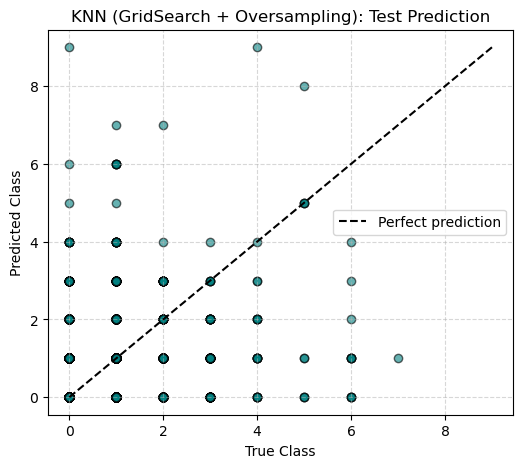

In [3]:
# ==========================================
# KNN (GridSearch + Oversampling): Prediction and Visualization
# ==========================================

# Predict test data
y_pred_knn = best_model.predict(X_test)

# (Optional) Check model performance numerically
print("\n🎯 KNN (GridSearch + Oversampling) Test Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, digits=3))

# ==========================================
# Plot: True vs Predicted (same style as RF/GB)
# ==========================================
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_knn, color='teal', alpha=0.6, edgecolors='k')
plt.plot([0,9], [0,9], 'k--', label='Perfect prediction')
plt.title("KNN (GridSearch + Oversampling): Test Prediction")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


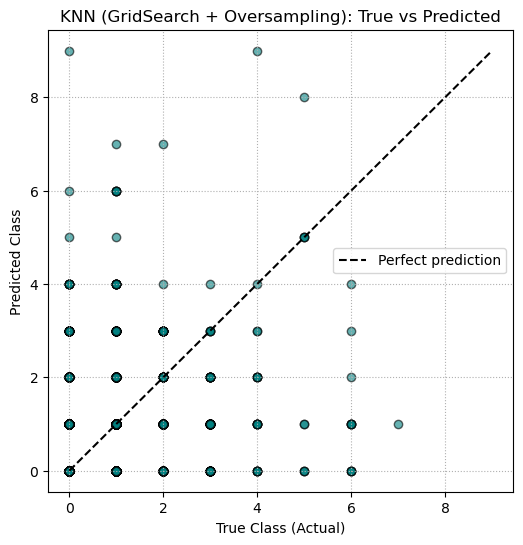

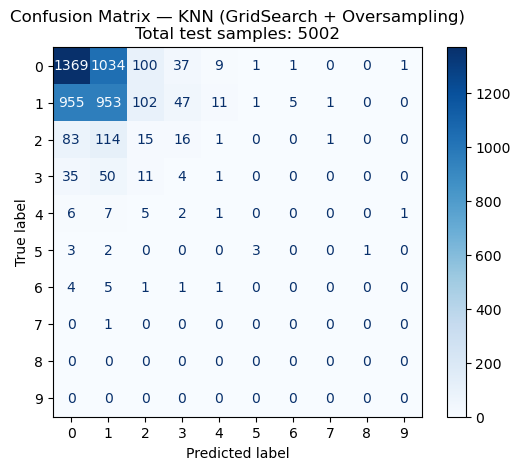


✅ KNN (GridSearch + Oversampling) Evaluation Summary:
Accuracy: 0.469
F1 (macro): 0.157
F1 (weighted): 0.470

Classification Report:
              precision    recall  f1-score   support

           0      0.558     0.536     0.547      2552
           1      0.440     0.459     0.449      2075
           2      0.064     0.065     0.065       230
           3      0.037     0.040     0.038       101
           4      0.042     0.045     0.043        22
           5      0.600     0.333     0.429         9
           6      0.000     0.000     0.000        12
           7      0.000     0.000     0.000         1
           8      0.000     0.000     0.000         0
           9      0.000     0.000     0.000         0

    accuracy                          0.469      5002
   macro avg      0.174     0.148     0.157      5002
weighted avg      0.472     0.469     0.470      5002



In [4]:
# ============================================================
# 📊 Visualization and Evaluation — KNN (GridSearch + Oversampling)
# ============================================================
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

# --- 1️⃣ Scatter Plot: True vs Predicted ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal', edgecolors='k')
plt.plot([0,9], [0,9], 'k--', label='Perfect prediction')
plt.xlabel("True Class (Actual)")
plt.ylabel("Predicted Class")
plt.title("KNN (GridSearch + Oversampling): True vs Predicted")
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

# --- 2️⃣ Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=range(10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap="Blues", values_format='d')
plt.title(f"Confusion Matrix — KNN (GridSearch + Oversampling)\nTotal test samples: {len(y_test)}")
plt.show()

# --- 3️⃣ Accuracy & F1-scores ---
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("\n✅ KNN (GridSearch + Oversampling) Evaluation Summary:")
print(f"Accuracy: {acc:.3f}")
print(f"F1 (macro): {f1_macro:.3f}")
print(f"F1 (weighted): {f1_weighted:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))
